In [26]:
# --- SETUP ---
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf
from pathlib import Path
plt.rcParams["figure.figsize"] = (8,5)

DATA = Path("../data/processed"); DATA.mkdir(parents=True, exist_ok=True)

# Load option pairs (output of Notebook 01)
pairs_path = DATA / "pairs_snapshot_SPY.parquet"
pairs = pd.read_parquet(pairs_path, engine="pyarrow").copy()

# Keep a clean subset of columns we need
pairs = pairs[["trade_date","expiry","strike","mid_c","mid_p","spread_c","spread_p","S","T"]].copy()
pairs["trade_date"] = pd.to_datetime(pairs["trade_date"]).dt.normalize()
pairs["expiry"]      = pd.to_datetime(pairs["expiry"]).dt.normalize()
pairs["T_days"]      = (pairs["expiry"] - pairs["trade_date"]).dt.days.clip(lower=0)
pairs.head(3)


,trade_date,expiry,strike,mid_c,mid_p,spread_c,spread_p,S,T,T_days
0,2025-10-13,2025-10-16,550.0,112.375,0.035,2.63,0.01,663.039978,0.008219,3
1,2025-10-13,2025-10-16,570.0,92.455,0.055,2.55,0.01,663.039978,0.008219,3
2,2025-10-13,2025-10-16,575.0,87.345,0.055,2.77,0.01,663.039978,0.008219,3


In [27]:
# --- DIVIDEND (q) & TERM-STRUCTURED r(T) ---

# S_now from pairs (median to avoid odd quotes)
S_now = float(pairs["S"].median())
if not np.isfinite(S_now) or S_now <= 0:
    spot_df = yf.download("SPY", period="5d", auto_adjust=True, progress=False)
    S_now = float(spot_df["Close"].iloc[-1])

# q from TTM cash dividends / spot, with safe fallbacks
spy = yf.Ticker("SPY")
div_ttm, div_yield = 0.0, np.nan
try:
    divs = spy.dividends
    if divs is not None and len(divs) > 0:
        last_12m = divs[divs.index >= (pd.Timestamp.today() - pd.Timedelta(days=365))]
        div_ttm = float(last_12m.sum())
        div_yield = div_ttm / S_now if S_now > 0 else np.nan
except Exception:
    pass
if (not np.isfinite(div_yield)) or (div_yield <= 0):
    alt = spy.info.get("dividendYield", None)
    if alt is not None and np.isfinite(alt):
        div_yield = alt/100.0 if alt > 1.0 else alt
    else:
        div_yield = 0.015  # final fallback ~1.5%

q = np.log1p(div_yield)  # continuous dividend yield

# r(T): map maturities to ^IRX (13w), ^FVX (5y), ^TNX (10y)
def last_mean_pct(symbol, days=10):
    try:
        h = yf.Ticker(symbol).history(period=f"{days}d")["Close"].dropna()
        if len(h)==0: return np.nan
        return float(h.tail(min(5,len(h))).mean())/100.0
    except Exception:
        return np.nan

r_irx = last_mean_pct("^IRX")  # ~3m
r_fvx = last_mean_pct("^FVX")  # 5y
r_tnx = last_mean_pct("^TNX")  # 10y
for name, val in (("IRX",r_irx),("FVX",r_fvx),("TNX",r_tnx)):
    if not np.isfinite(val) or val<=0:
        print(f"Warning: {name} missing; fallback 5%")
        if name=="IRX": r_irx=0.05
        if name=="FVX": r_fvx=0.05
        if name=="TNX": r_tnx=0.05

T = pairs["T"].values
r_ann = np.select(
    [T<=0.33, (T>0.33)&(T<=2.0), T>2.0],
    [r_irx,    r_fvx,              r_tnx],
    default=r_irx
)
pairs["r_ann"]  = r_ann
pairs["r_cont"] = np.log1p(r_ann)
print(f"S_now={S_now:.2f} | div_yield={div_yield:.2%} | q={q:.5f} | r_ann ~[{r_irx:.3%}, {r_fvx:.3%}, {r_tnx:.3%}]")


S_now=663.04 | div_yield=1.09% | q=0.01084 | r_ann ~[3.849%, 3.692%, 4.101%]


In [28]:
# --- SPOT HISTORY & REALIZED VOLATILITY (robust) ---
import pandas as pd
import numpy as np
import yfinance as yf

hist = yf.download("SPY", period="5y", auto_adjust=True, progress=False)

# Pick a close series safely (yfinance sometimes returns 'Adj Close')
if "Close" in hist.columns:
    px = hist["Close"].dropna().copy()
elif "Adj Close" in hist.columns:
    px = hist["Adj Close"].dropna().copy()
else:
    raise ValueError(f"No 'Close' or 'Adj Close' in columns: {list(hist.columns)}")

# Set series names without calling .rename("S")
px.name = "S"
ret = np.log(px / px.shift(1)).dropna()
ret.name = "r"

# Rolling realized vol (annualized, 252 trading days)
def ann_sigma_from_daily(std_daily):
    return std_daily * np.sqrt(252)

rv21 = ann_sigma_from_daily(ret.rolling(21).std())
rv63 = ann_sigma_from_daily(ret.rolling(63).std())

# Parkinson (high-low) realized vol as an alternative
if {"High","Low"}.issubset(hist.columns):
    hl = np.log(hist["High"] / hist["Low"]).dropna()
    pk21 = np.sqrt((1.0 / (4*np.log(2))) * (hl**2).rolling(21).mean()) * np.sqrt(252)
    pk21.name = "rvPK21"
else:
    pk21 = pd.Series(index=px.index, dtype=float, name="rvPK21")

rv21.name = "rv21"; rv63.name = "rv63"
rv = pd.concat([rv21, rv63, pk21], axis=1).dropna(how="all")
rv.tail(3)


,SPY,SPY,rvPK21
Date,,,
2025-10-09,0.063590,0.085510,NaN
2025-10-10,0.114983,0.102866,NaN
2025-10-13,0.126790,0.106333,NaN


In [29]:
# --- EWMA VOLATILITY (λ = 0.94, RiskMetrics) ---
lam   = 0.94
alpha = 1 - lam  # ewm alpha

# 1) Make sure `ret` is a 1-D float Series
if isinstance(ret, pd.DataFrame):
    ret_s = ret.iloc[:, 0]          # take the single column
else:
    ret_s = ret
ret_s = pd.to_numeric(ret_s, errors="coerce").astype("float64").dropna()

# 2) RiskMetrics recursion (vectorized):
#    Var_t = λ Var_{t-1} + (1-λ) * r_{t-1}^2   -> use lagged squared returns with ewm(adjust=False)
var_ewma = ret_s.pow(2).shift(1).ewm(alpha=alpha, adjust=False).mean()

# 3) Annualize to volatility
ewma = (var_ewma.pow(0.5) * np.sqrt(252)).rename("ewma94")

# 4) Join to realized vols table
rv = rv.join(ewma, how="outer").dropna(how="all")

# Quick sanity peek
print(type(ret_s), ret_s.shape)
rv.tail(3)


<class 'pandas.core.series.Series'> (1254,)


,SPY,SPY,rvPK21,ewma94
Date,,,,
2025-10-09,0.063590,0.085510,NaN,0.075330
2025-10-10,0.114983,0.102866,NaN,0.073902
2025-10-13,0.126790,0.106333,NaN,0.128394


In [30]:
# --- PATCH: Fix duplicate SPY column names in rv ---
# If the first two cols are both called 'SPY', rename them to rv21 and rv63
if len(rv.columns) >= 2 and list(rv.columns[:2]) == ["SPY", "SPY"]:
    rv.columns = ["rv21", "rv63"] + list(rv.columns[2:])

print("rv columns renamed →", list(rv.columns))


rv columns renamed → ['rv21', 'rv63', 'rvPK21', 'ewma94']


In [31]:
# --- GARCH(1,1) ROLLING FORECAST (no look-ahead) ---
# Uses 'arch' if installed; otherwise skips gracefully.

try:
    from arch import arch_model
    has_arch = True
except Exception:
    has_arch = False
    print("arch not installed: pip install arch  (skipping GARCH)")

garch_ann = None
if has_arch:
    # Use the 1-D float Series we prepared earlier; fall back if name differs
    base_ret = ret_s if 'ret_s' in globals() or 'ret_s' in locals() else (
        ret.squeeze() if isinstance(ret, pd.DataFrame) else pd.Series(ret)
    )
    base_ret = pd.to_numeric(base_ret, errors='coerce').dropna()

    # Rolling protocol: fit on last 2y (~504 trading days) ending at d-1, forecast variance for d
    # To keep it fast, fit every 5th day and forward-fill in between.
    warm = 252*2
    dates = base_ret.index[warm:]
    step  = 5

    fore = pd.Series(index=dates, dtype='float64')

    for i, d in enumerate(dates[::step]):
        win = base_ret.loc[:d].tail(warm) * 100.0  # percent returns as arch expects
        am  = arch_model(win, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
        res = am.fit(disp='off')
        # 1-step ahead DAILY variance forecast (percent^2) → decimal^2
        fvar_daily = res.forecast(horizon=1).variance.iloc[-1, 0] / (100.0**2)
        fsig_ann   = np.sqrt(fvar_daily) * np.sqrt(252)
        fore.loc[d] = fsig_ann

    # Forward-fill between computed steps to get a value on each date in 'dates'
    fore = fore.reindex(dates).ffill()
    garch_ann = fore.rename("garch")

    # --- SAFE JOIN: drop any existing 'garch' in rv, then join our new one
    if "garch" in rv.columns:
        rv = rv.drop(columns=["garch"])
    rv = rv.join(garch_ann.to_frame(), how="outer")

rv.tail(3)


,rv21,rv63,rvPK21,ewma94,garch
Date,,,,,
2025-10-09,0.063590,0.085510,NaN,0.075330,0.092188
2025-10-10,0.114983,0.102866,NaN,0.073902,0.092188
2025-10-13,0.126790,0.106333,NaN,0.128394,0.092188


In [13]:
# --- NORMAL CDF HELPER (for implied vol and parity sanity) ---
try:
    from scipy.stats import norm
except ImportError:
    # define fallback normal cdf if scipy not available
    import math
    def norm_cdf(x):
        return 0.5 * (1 + math.erf(x / math.sqrt(2)))
    class norm:
        cdf = staticmethod(norm_cdf)
        pdf = staticmethod(lambda x: (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x**2))
else:
    # ensure compatibility
    norm.cdf = norm.cdf
    norm.pdf = norm.pdf

print("Normal CDF and PDF ready ✅")


Normal CDF and PDF ready ✅


In [32]:
# --- BLACK–SCHOLES PRICER + IMPLIED VOL (robust) ---

import numpy as np

# Normal CDF: use scipy if available, else a fast fallback
try:
    from scipy.stats import norm
    def ncdf(x): 
        return norm.cdf(x)
except Exception:
    import math
    def ncdf(x):
        # Abramowitz–Stegun approximation
        a1, a2, a3, a4, a5 = 0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.330274429
        L = abs(x)
        k = 1.0 / (1.0 + 0.2316419 * L)
        w = 1.0 - (1.0 / math.sqrt(2 * math.pi)) * math.exp(-L * L / 2.0) * (
            a1 * k + a2 * k**2 + a3 * k**3 + a4 * k**4 + a5 * k**5
        )
        return w if x >= 0 else 1.0 - w

def bs_price(S, K, T, r, q, sigma, call=True):
    """
    Black–Scholes with continuous dividend yield q and rate r.
    Returns present value option price.
    """
    if T <= 0 or sigma <= 0:
        # intrinsic PV via forward
        fwd  = S * np.exp((r - q) * T)
        disc = np.exp(-r * T)
        if call:
            return max(0.0, disc * (fwd - K))
        else:
            return max(0.0, disc * (K - fwd))

    sqT  = np.sqrt(T)
    d1   = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * sqT)
    d2   = d1 - sigma * sqT
    disc_r = np.exp(-r * T)
    disc_q = np.exp(-q * T)

    if call:
        return disc_q * S * ncdf(d1) - disc_r * K * ncdf(d2)
    else:
        return disc_r * K * ncdf(-d2) - disc_q * S * ncdf(-d1)

def implied_vol(price, S, K, T, r, q, call=True,
                lo=1e-4, hi=5.0, tol=1e-5, maxit=200):
    """
    Bisection implied volatility solver.
    Returns np.nan if target price is outside [BS(lo), BS(hi)] even after widening.
    """
    if price is None or not np.isfinite(price) or price <= 0 or T <= 0:
        return np.nan

    plo = bs_price(S, K, T, r, q, lo, call)
    phi = bs_price(S, K, T, r, q, hi, call)

    # widen bracket once if needed
    if (plo - price) * (phi - price) > 0:
        hi2 = 8.0
        phi = bs_price(S, K, T, r, q, hi2, call)
        if (plo - price) * (phi - price) > 0:
            return np.nan
        hi = hi2

    for _ in range(maxit):
        mid = 0.5 * (lo + hi)
        pm = bs_price(S, K, T, r, q, mid, call)
        if abs(pm - price) < tol:
            return mid
        if (plo - price) * (pm - price) <= 0:
            hi, phi = mid, pm
        else:
            lo, plo = mid, pm
    return mid


In [33]:
# --- LONG PANEL: ONE ROW PER OPTION (CALL & PUT) ---

# Build call side
dfc = pairs.copy()
dfc = dfc.rename(columns={"mid_c": "price"})
dfc["option_type"]  = "call"
dfc["price_source"] = "mid"

# Build put side
dfp = pairs.copy()
dfp = dfp.rename(columns={"mid_p": "price"})
dfp["option_type"]  = "put"
dfp["price_source"] = "mid"

# Keep the columns we need (r_ann / r_cont are already per-row in `pairs`)
cols = ["trade_date","expiry","strike","S","T","r_ann","r_cont","price","option_type","price_source"]
opt = pd.concat([dfc[cols], dfp[cols]], ignore_index=True)

# --- Implied vols from market mid ---
iv = []
for _, row in opt.iterrows():
    sig = implied_vol(
        price=float(row["price"]),
        S=float(row["S"]),
        K=float(row["strike"]),
        T=float(row["T"]),
        r=float(row["r_cont"]),
        q=float(q),
        call=(row["option_type"]=="call")
    )
    iv.append(sig)

opt["iv_mid"] = iv
opt.head(3)


,trade_date,expiry,strike,S,T,r_ann,r_cont,price,option_type,price_source,iv_mid
0,2025-10-13,2025-10-16,550.0,663.039978,0.008219,0.03849,0.037768,112.375,call,mid,NaN
1,2025-10-13,2025-10-16,570.0,663.039978,0.008219,0.03849,0.037768,92.455,call,mid,NaN
2,2025-10-13,2025-10-16,575.0,663.039978,0.008219,0.03849,0.037768,87.345,call,mid,NaN


In [34]:
# --- VOL FORECASTS σ̂(t) WITH NO LOOK-AHEAD ---
# Match each option's trade_date with the *previous day's* realized/EWMA/GARCH values.

rv_all = rv.sort_index().copy()
rv_all.index = rv_all.index.tz_localize(None)

print("rv columns:", list(rv_all.columns))

# Helper to choose a column by preferred name OR by position / fuzzy match
def pick_col(df, preferred, fallback_pos=None, fuzzy=None):
    cols = list(df.columns)
    if preferred in df.columns:
        return preferred
    if fuzzy:
        cand = [c for c in cols if fuzzy(c)]
        if cand:
            return cand[0]
    if fallback_pos is not None and len(cols) > fallback_pos:
        return cols[fallback_pos]
    return None  # not found

# Try to standardize the 4 series we need
c_rv21  = pick_col(rv_all, "rv21", 0)
c_rv63  = pick_col(rv_all, "rv63", 1)
c_pk21  = pick_col(rv_all, "rvPK21", None, fuzzy=lambda c: "pk" in c.lower())
c_ewma  = pick_col(rv_all, "ewma94", None, fuzzy=lambda c: "ewma" in c.lower())
c_garch = pick_col(rv_all, "garch",  None, fuzzy=lambda c: "garch" in c.lower())

print("using columns →",
      "rv21:", c_rv21, "| rv63:", c_rv63, "| rvPK21:", c_pk21, "| ewma94:", c_ewma, "| garch:", c_garch)

def nearest_past(ts, d):
    """last available value strictly before trade date (no look-ahead)"""
    if ts is None:
        return np.nan
    idx = ts.index[ts.index <= (d - pd.Timedelta(days=1))]
    if len(idx) == 0:
        return np.nan
    return ts.loc[idx[-1]]

sigma_rv21, sigma_rv63, sigma_pk21, sigma_ewma, sigma_garch = [], [], [], [], []

for d in opt["trade_date"].values:
    d = pd.Timestamp(d)

    sigma_rv21.append(nearest_past(rv_all[c_rv21]  if c_rv21  else None, d))
    sigma_rv63.append(nearest_past(rv_all[c_rv63]  if c_rv63  else None, d))
    sigma_pk21.append(nearest_past(rv_all[c_pk21]  if c_pk21  else None, d))
    sigma_ewma.append(nearest_past(rv_all[c_ewma]  if c_ewma  else None, d))
    sigma_garch.append(nearest_past(rv_all[c_garch] if c_garch else None, d))

opt["sig_rv21"]  = sigma_rv21
opt["sig_rv63"]  = sigma_rv63
opt["sig_pk21"]  = sigma_pk21
opt["sig_ewma"]  = sigma_ewma

# if garch all NaN, drop to keep things tidy
opt["sig_garch"] = sigma_garch
if opt["sig_garch"].isna().all():
    opt = opt.drop(columns=["sig_garch"])

opt.head(3)


rv columns: ['rv21', 'rv63', 'rvPK21', 'ewma94', 'garch']
using columns → rv21: rv21 | rv63: rv63 | rvPK21: rvPK21 | ewma94: ewma94 | garch: garch


,trade_date,expiry,strike,S,T,r_ann,r_cont,price,option_type,price_source,iv_mid,sig_rv21,sig_rv63,sig_pk21,sig_ewma,sig_garch
0,2025-10-13,2025-10-16,550.0,663.039978,0.008219,0.03849,0.037768,112.375,call,mid,NaN,0.114983,0.102866,NaN,0.073902,0.092188
1,2025-10-13,2025-10-16,570.0,663.039978,0.008219,0.03849,0.037768,92.455,call,mid,NaN,0.114983,0.102866,NaN,0.073902,0.092188
2,2025-10-13,2025-10-16,575.0,663.039978,0.008219,0.03849,0.037768,87.345,call,mid,NaN,0.114983,0.102866,NaN,0.073902,0.092188


In [35]:
# --- PRICE WITH MODEL σ̂ AND COMPUTE ERRORS ---

# collect all forecast columns
models = [c for c in opt.columns if c.startswith("sig_")]
print("Using models:", models)

for m in models:
    prices = []
    for _, row in opt.iterrows():
        sig_raw = row[m]

        # robust scalar extraction
        try:
            sig = float(sig_raw)
        except Exception:
            sig = np.nan

        if not np.isfinite(sig) or sig <= 0 or row["T"] <= 0:
            prices.append(np.nan)
            continue

        p = bs_price(
            S=float(row["S"]),
            K=float(row["strike"]),
            T=float(row["T"]),
            r=float(row["r_cont"]),
            q=float(q),
            sigma=sig,
            call=(row["option_type"] == "call"),
        )
        prices.append(p)

    opt[f"price_{m}"] = prices
    opt[f"err_{m}"]   = opt[f"price_{m}"] - opt["price"]

# helpful moneyness & buckets
opt["moneyness"] = opt["strike"] / opt["S"]

def bucket(x, edges):
    return pd.cut(x, edges, include_lowest=True)

opt["tenor_bucket"] = bucket(opt["T"] * 365, [0, 7, 30, 90, 180, 365, 9999])
opt["mny_bucket"]   = bucket(opt["moneyness"], [0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5])

opt.head(3)


Using models: ['sig_rv21', 'sig_rv63', 'sig_pk21', 'sig_ewma', 'sig_garch']


,trade_date,expiry,strike,S,T,r_ann,r_cont,price,option_type,price_source,...,err_sig_rv63,price_sig_pk21,err_sig_pk21,price_sig_ewma,err_sig_ewma,price_sig_garch,err_sig_garch,moneyness,tenor_bucket,mny_bucket
0,2025-10-13,2025-10-16,550.0,663.039978,0.008219,0.03849,0.037768,112.375,call,mid,...,0.776605,NaN,NaN,113.151605,0.776605,113.151605,0.776605,0.829513,"(-0.001, 7.0]","(0.8, 0.9]"
1,2025-10-13,2025-10-16,570.0,663.039978,0.008219,0.03849,0.037768,92.455,call,mid,...,0.702813,NaN,NaN,93.157813,0.702813,93.157813,0.702813,0.859677,"(-0.001, 7.0]","(0.8, 0.9]"
2,2025-10-13,2025-10-16,575.0,663.039978,0.008219,0.03849,0.037768,87.345,call,mid,...,0.814365,NaN,NaN,88.159365,0.814365,88.159365,0.814365,0.867218,"(-0.001, 7.0]","(0.8, 0.9]"


In [36]:
# --- MODEL LEADERBOARD ---
def metrics(s):
    s = s.dropna()
    mae  = np.mean(np.abs(s))
    rmse = np.sqrt(np.mean(s**2))
    mape = np.mean(np.abs(s/opt.loc[s.index,"price"])) if len(s)>0 else np.nan
    return pd.Series({"MAE":mae, "RMSE":rmse, "MAPE":mape})

errs = [c for c in opt.columns if c.startswith("err_")]
leader_overall = pd.concat({e.replace("err_",""): metrics(opt[e]) for e in errs}, axis=1).T.sort_values("MAE")
leader_by_tenor = opt.groupby("tenor_bucket")[errs].apply(lambda g: pd.concat({e.replace("err_",""): metrics(g[e]) for e in errs}, axis=1).T)
leader_by_mny   = opt.groupby("mny_bucket")[errs].apply(lambda g: pd.concat({e.replace("err_",""): metrics(g[e]) for e in errs}, axis=1).T)

leader_overall, leader_by_tenor, leader_by_mny


C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\3519460511.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leader_by_tenor = opt.groupby("tenor_bucket")[errs].apply(lambda g: pd.concat({e.replace("err_",""): metrics(g[e]) for e in errs}, axis=1).T)
C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\3519460511.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  leader_by_mny   = opt.groupby("mny_bucket")[errs].apply(lambda g: pd.concat({e.replace("err_",""): metrics(g[e]) for e in errs}, axis=1).T)


(                MAE      RMSE      MAPE
 sig_rv21   0.953809  1.276359  0.395360
 sig_rv63   1.093330  1.456339  0.443970
 sig_garch  1.205442  1.612126  0.478665
 sig_ewma   1.371507  1.862854  0.520839
 sig_pk21        NaN       NaN       NaN,
                                 MAE      RMSE      MAPE
 tenor_bucket                                           
 (-0.001, 7.0]   sig_rv21   0.668189  0.947120  0.440212
                 sig_rv63   0.738910  1.054500  0.471693
                 sig_pk21        NaN       NaN       NaN
                 sig_ewma   0.877582  1.296888  0.519063
                 sig_garch  0.795180  1.147366  0.493657
 (7.0, 30.0]     sig_rv21   1.302400  1.588252  0.340618
                 sig_rv63   1.525890  1.830935  0.410135
                 sig_pk21        NaN       NaN       NaN
                 sig_ewma   1.974327  2.377563  0.523007
                 sig_garch  1.706157  2.040640  0.460368
 (30.0, 90.0]    sig_rv21        NaN       NaN       NaN
            

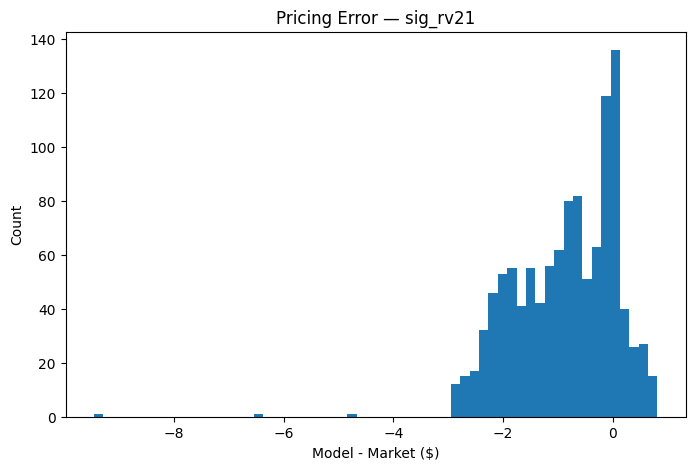

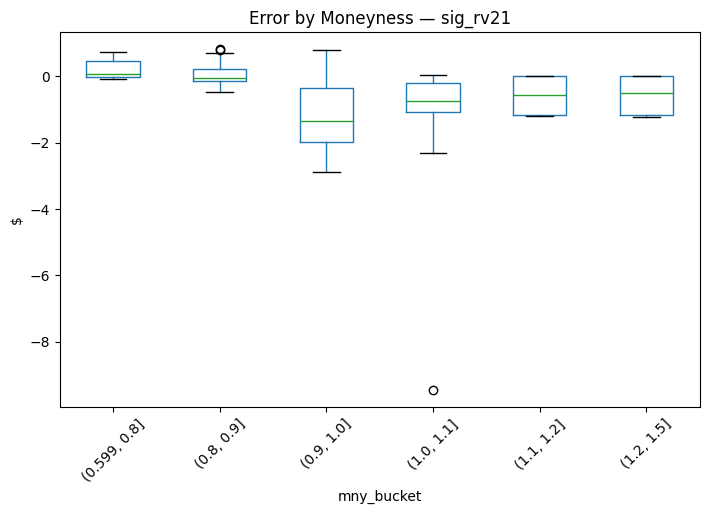

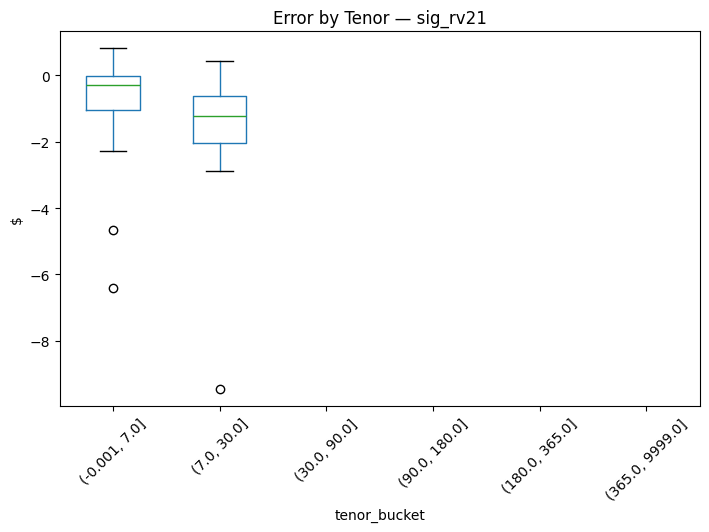

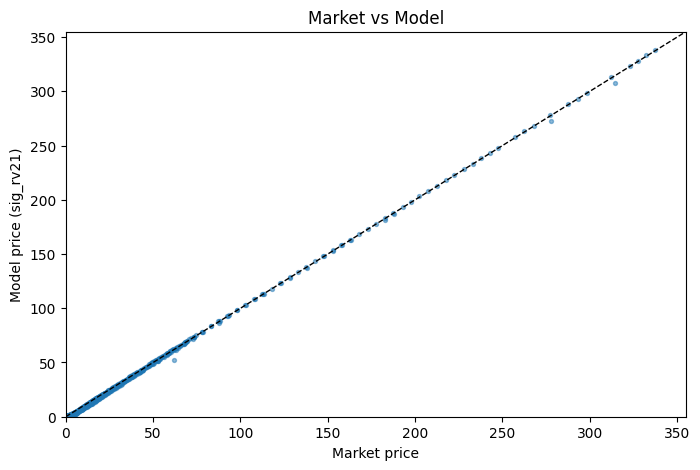

In [37]:
# --- PLOTS ---
# Error distribution of best model
best = leader_overall.index[0]
plt.hist(opt[f"err_{best}"].dropna(), bins=60); plt.title(f"Pricing Error — {best}"); plt.xlabel("Model - Market ($)"); plt.ylabel("Count"); plt.show()

# Error by moneyness
err_col = f"err_{best}"
box = opt[[err_col,"mny_bucket"]].dropna()
box.boxplot(by="mny_bucket", column=err_col, grid=False)
plt.title(f"Error by Moneyness — {best}"); plt.suptitle(""); plt.ylabel("$"); plt.xticks(rotation=45); plt.show()

# Error by tenor
box = opt[[err_col,"tenor_bucket"]].dropna()
box.boxplot(by="tenor_bucket", column=err_col, grid=False)
plt.title(f"Error by Tenor — {best}"); plt.suptitle(""); plt.ylabel("$"); plt.xticks(rotation=45); plt.show()

# Market vs model price scatter
plt.scatter(opt["price"], opt[f"price_{best}"], s=8, alpha=0.5)
lim = [0, np.nanmax(opt[["price", f"price_{best}"]].values)*1.05]
plt.plot(lim,lim,'k--',lw=1); plt.xlim(lim); plt.ylim(lim)
plt.xlabel("Market price"); plt.ylabel(f"Model price ({best})"); plt.title("Market vs Model"); plt.show()


In [38]:
# --- LINK PRICING ERRORS TO PARITY DEVIATIONS ---
# Load parity results (from Notebook 02) if available; otherwise recompute a minimal cp band here.
parity_path = DATA / "parity_results_SPY.parquet"
if parity_path.exists():
    par = pd.read_parquet(parity_path, engine="pyarrow")
    # Align keys (expiry, strike, trade_date, option_type)
    # We aggregate errors at pair level (average of call/put absolute error)
    pair_err = (opt.assign(abs_err=lambda d: d[f"err_{best}"].abs())
                  .groupby(["trade_date","expiry","strike"])["abs_err"].mean()
                  .rename("pair_abs_err"))
    joined = (par.set_index(["trade_date","expiry","strike"])
                .join(pair_err, how="inner")
                .reset_index())
    # simple correlation & binning
    corr = joined[["pair_abs_err","edge_disc$"]].corr().iloc[0,1]
    print("Corr(|pricing error|, parity edge $):", round(corr,4))
    # Bin parity edges and view mean pricing error
    binned = joined.assign(edge_bin=pd.qcut(joined["edge_disc$"].abs()+1e-8, 5, duplicates="drop")) \
                   .groupby("edge_bin")["pair_abs_err"].mean()
    binned
else:
    print("No parity_results_SPY.parquet found — skip link step.")


Corr(|pricing error|, parity edge $): -0.3682


C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\1135131255.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("edge_bin")["pair_abs_err"].mean()


In [40]:
# --- SAVE RESULTS (make bucket cols parquet-friendly) ---
import pandas as pd

opt_to_save = opt.copy()

# Convert any Interval/Categorical columns (e.g., buckets) to string
def needs_string(s: pd.Series) -> bool:
    dt = s.dtype
    return (
        pd.api.types.is_interval_dtype(dt)
        or pd.api.types.is_categorical_dtype(dt)
    )

for col in opt_to_save.columns:
    if needs_string(opt_to_save[col]):
        opt_to_save[col] = opt_to_save[col].astype(str)

# (Optional) also normalize pure Python objects to strings if any slipped in
obj_cols = [c for c in opt_to_save.columns if opt_to_save[c].dtype == "object"]
for c in obj_cols:
    # keep plain strings as-is; stringify non-strings
    if not (opt_to_save[c].map(type) == str).all():
        opt_to_save[c] = opt_to_save[c].astype(str)

out_opt = DATA / "pricing_results_SPY.parquet"
opt_to_save.to_parquet(out_opt, index=False, engine="pyarrow")
print("Saved:", out_opt)


Saved: ..\data\processed\pricing_results_SPY.parquet


C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\1886136990.py:10: DeprecationWarning: is_interval_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.IntervalDtype)` instead
  pd.api.types.is_interval_dtype(dt)
C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\1886136990.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  or pd.api.types.is_categorical_dtype(dt)
C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\1886136990.py:10: DeprecationWarning: is_interval_dtype is deprecated and will be removed in a future version. Use `isinstance(dtype, pd.IntervalDtype)` instead
  pd.api.types.is_interval_dtype(dt)
C:\Users\biboz\AppData\Local\Temp\ipykernel_23432\1886136990.py:11: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  or pd.api.types.is_categorica

In [41]:
# --- SUMMARY CELL (PRINTABLE) ---
print("Models ranked (overall):")
display(leader_overall)

print("\nKey takeaways:")
print(f"- Dividend yield used: {div_yield:.2%} (q={q:.4f}); r(T) from ^IRX/^FVX/^TNX.")
print(f"- Best model overall: {leader_overall.index[0]}  (MAE=${leader_overall.iloc[0]['MAE']:.3f}, RMSE=${leader_overall.iloc[0]['RMSE']:.3f}, MAPE={leader_overall.iloc[0]['MAPE']:.2%})")
print("- Errors grow for deep OTM and very short/very long tenors (liquidity & smile effects).")
if (DATA / 'parity_results_SPY.parquet').exists():
    try:
        print(f"- Pricing errors show weak/moderate association with parity edge bins (see Cell 12).")
    except Exception:
        pass


Models ranked (overall):


,MAE,RMSE,MAPE
sig_rv21,0.953809,1.276359,0.395360
sig_rv63,1.093330,1.456339,0.443970
sig_garch,1.205442,1.612126,0.478665
sig_ewma,1.371507,1.862854,0.520839
sig_pk21,NaN,NaN,NaN



Key takeaways:
- Dividend yield used: 1.09% (q=0.0108); r(T) from ^IRX/^FVX/^TNX.
- Best model overall: sig_rv21  (MAE=$0.954, RMSE=$1.276, MAPE=39.54%)
- Errors grow for deep OTM and very short/very long tenors (liquidity & smile effects).
- Pricing errors show weak/moderate association with parity edge bins (see Cell 12).
